In [169]:
import pandas
import datetime
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf

In [170]:
df = pandas.read_csv("AirQualityUCI.csv", sep = ";", decimal = ",")
df = df.iloc[ : , 0:14]

In [171]:
len(df)

9471

In [172]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6


In [173]:
df = df[df["Date"].notnull()]

In [174]:
df.isna().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
dtype: int64

In [175]:
df['DateTime'] = (df.Date) + ' ' + (df.Time)
print(type(df.DateTime[0]))
df.DateTime = df.DateTime.apply(lambda x: datetime.datetime.strptime(x,
'%d/%m/%Y %H.%M.%S'))
print (type(df.DateTime[0]))

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


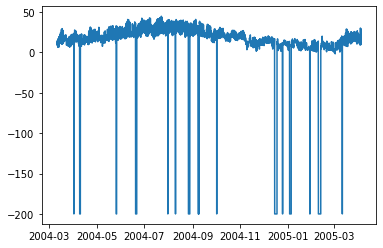

In [176]:
df.index = df.DateTime
plt.plot(df['T'])

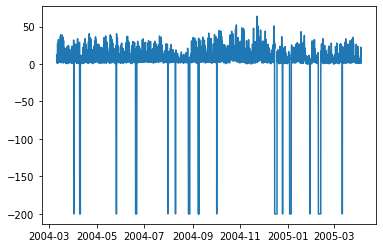

In [177]:
plt.plot(df['C6H6(GT)'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f974c38b850>,
 'caps': [<matplotlib.lines.Line2D at 0x7f974c38bf70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f974c38b4c0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f974c3966d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f974c396a60>,
 'means': []}

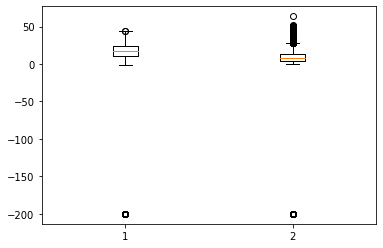

In [178]:
plt.boxplot(df[['T','C6H6(GT)']].values)

# 1st Naive method 

In [179]:
print ('Mean: ', numpy.mean(df['T']), '; \nStandard Deviation:', numpy.std(df['T']),'; \nMaximum Temperature: ',max(df['T']),'; \nMinimumTemperature: ',min(df['T']))

Mean:  9.778305012290264 ; 
Standard Deviation: 43.201314375146595 ; 
Maximum Temperature:  44.6 ; 
MinimumTemperature:  -200.0


In [180]:
df['T']
df['T_t-1'] = df['T'].shift(1)
df_naive = df[['T','T_t-1']][1:]

In [181]:
true = df_naive['T']
prediction = df_naive['T_t-1']
error = sqrt(metrics.mean_squared_error(true, prediction))
print('RSME for Naive method 1: ', error)

RSME for Naive method 1:  12.901140576492974


# 2nd Naive Method

In [182]:
df['T_rm'] = df['T'].rolling(3).mean().shift(1)
df_naive = df[['T', 'T_rm']].dropna()

In [183]:
true = df_naive['T']
prediction = df_naive['T_rm']
error = sqrt(metrics.mean_squared_error(true, prediction))
print('RSME for Naive method 2: ', error)

RSME for Naive method 2:  14.957633272839242


# Auto Regression

## Creating ACP (Auto-Correlation Plot) for data

In [184]:
split = len(df) - int(0.2*len(df))
train, test = df['T'][0:split], df['T'][split:]

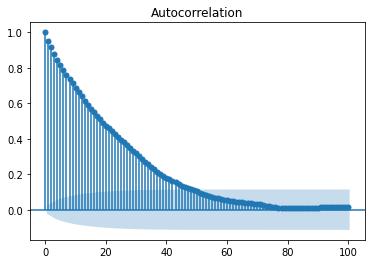

In [185]:
plot_acf(train, lags = 100)
plt.show()

# Moving Average

## Creating PACP (Partial auto-correlation plot)

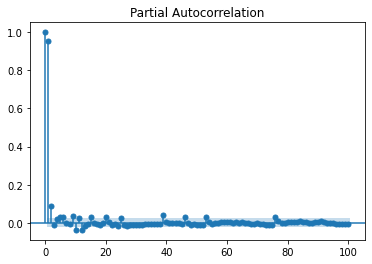

In [186]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train, lags = 100)
plt.show()

In [187]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.406056
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [188]:
import hurst

H, c,data = hurst.compute_Hc(train)
print("H = {:.4f}, c = {:.4f}".format(H,c))

H = 0.1660, c = 5.0740


## Integrating ARIMA (Auto-regressive integrated moving average) model

In [189]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train.values, order=(5,0,2))
model_fit = model.fit(disp=False)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [190]:
prediction = model_fit.predict(len(test))
test_ = pandas.DataFrame(test)
test_['predictions'] = prediction[0:1871]

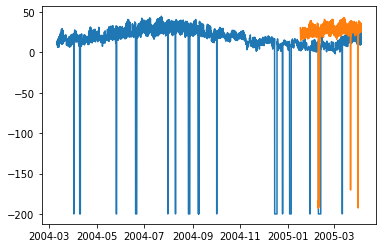

In [191]:
plt.plot(df['T'])
plt.plot(test_.predictions)
plt.show()

In [192]:
error = sqrt(metrics.mean_squared_error(test.values, prediction[0:1871]))
print ('Test RMSE for ARIMA: ', error)

Test RMSE for ARIMA:  43.21253400905608


# Variations of ARIMA

In [193]:
df_multi = df[['T', 'C6H6(GT)']]
split = len(df) - int(0.2*len(df))
train_multi, test_multi = df_multi[0:split], df_multi[split:]

In [194]:
from statsmodels.tsa.statespace.varmax import VARMAX

model = VARMAX(train_multi, order=(2,1))
model_fit = model.fit()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84202D+00    |proj g|=  2.30038D-02

At iterate    5    f=  6.84082D+00    |proj g|=  4.39891D-02

At iterate   10    f=  6.83909D+00    |proj g|=  1.71805D-02

At iterate   15    f=  6.83854D+00    |proj g|=  9.06473D-03

At iterate   20    f=  6.83793D+00    |proj g|=  1.19376D-03

At iterate   25    f=  6.83792D+00    |proj g|=  1.10146D-03

At iterate   30    f=  6.83792D+00    |proj g|=  1.52225D-03

At iterate   35    f=  6.83792D+00    |proj g|=  1.31771D-03

At iterate   40    f=  6.83789D+00    |proj g|=  7.52096D-03

At iterate   45    f=  6.83787D+00    |proj g|=  6.16140D-04

At iterate   50    f=  6.83786D+00    |proj g|=  1.74909D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [195]:
predictions_multi = model_fit.forecast( steps=len(test_multi))

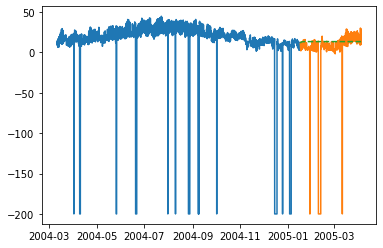

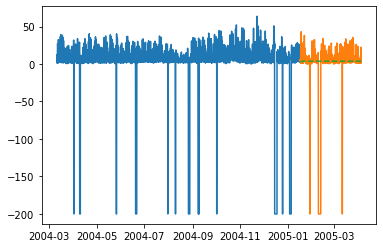

In [196]:
plt.plot(train_multi['T'])
plt.plot(test_multi['T'])
plt.plot(predictions_multi.iloc[:,0:1], '--')
plt.show()
plt.plot(train_multi['C6H6(GT)'])
plt.plot(test_multi['C6H6(GT)'])
plt.plot(predictions_multi.iloc[:,1:2], '--')
plt.show()

# Integrating SARIMAX (Seasonal Auto-regressive integrated moving averages with Exogenous Variables)

In [197]:
from scipy.stats.stats import pearsonr

x = train_multi['T'].values
y = train_multi['C6H6(GT)'].values

corr, p = pearsonr(x,y)
print('Correlation Coefficient: ', corr, '\n P-Value =', p)

Correlation Coefficient:  0.9701173437269854 
 P-Value = 0.0


In [198]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(x, exog = y, order = (2, 0, 2), seasonal_order = (2, 0, 1, 4), enforce_stationarity=False, enforce_invertibility = False)
model_fit = model.fit(disp = False)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [199]:
y_ = test_multi['C6H6(GT)'].values
predicted = model_fit.predict(exog=y_)
test_multi_ = pandas.DataFrame(test)
test_multi_['predictions'] = predicted[0:1871]

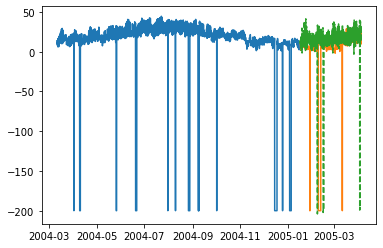

In [200]:
plt.plot(train_multi['T'])
plt.plot(test_multi_['T'])
plt.plot(test_multi_.predictions, '--')

# Exponential smoothing

In [201]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train.values )
model_fit = model.fit()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


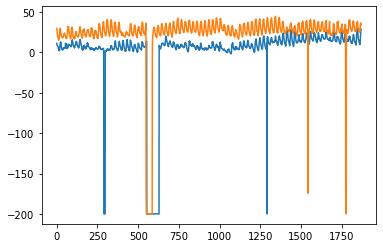

In [202]:
predictions_ = model_fit.predict(len(test))
plt.plot(test.values)
plt.plot(predictions_[1:1871])

## Walk forward validation

In [203]:
prediction = []
data = train.values
for t in test.values:
 model = (ExponentialSmoothing(data).fit())
 y = model.predict()
 prediction.append(y[0])
 data = numpy.append(data, t)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


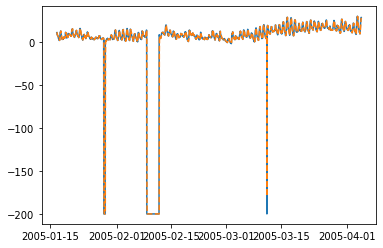

In [204]:
test_ = pandas.DataFrame(test)
test_['predictionswf'] = prediction
plt.plot(test_['T'])
plt.plot(test_.predictionswf, '--')
plt.show()

In [205]:
error = sqrt(metrics.mean_squared_error(test.values,prediction))
print ('Test RMSE for Triple Exponential Smoothing with Walk-ForwardValidation: ', error)

Test RMSE for Triple Exponential Smoothing with Walk-ForwardValidation:  11.787532735760955


# Implementing LSTM Model

## Teaching NN straight lines

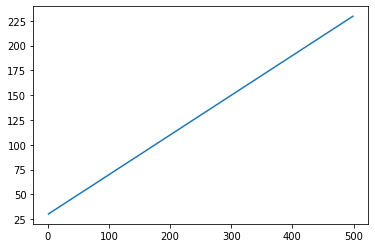

In [206]:
x = numpy.arange (1,500,1)
y = 0.4 * x + 30
plt.plot(x,y)

In [207]:
trainx, testx = x[0:int(0.8*(len(x)))], x[int(0.8*(len(x))):]
trainy, testy = y[0:int(0.8*(len(y)))], y[int(0.8*(len(y))):]
train = numpy.array(list(zip(trainx,trainy)))
test = numpy.array(list(zip(trainx,trainy)))

In [208]:
def create_dataset(n_X, look_back):
 dataX, dataY = [], []
 for i in range(len(n_X)-look_back):
    a = n_X[i:(i+look_back), ]
    dataX.append(a)
    dataY.append(n_X[i + look_back, ])
 return numpy.array(dataX), numpy.array(dataY)

In [209]:
look_back = 1
trainx,trainy = create_dataset(train, look_back)
testx,testy = create_dataset(test, look_back)
trainx = numpy.reshape(trainx, (trainx.shape[0], 1, 2))
testx = numpy.reshape(testx, (testx.shape[0], 1, 2))

In [210]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(trainx.shape[1], 2)))
model.add(LSTM(128,input_shape=(trainx.shape[1], 2)))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(trainx, trainy, epochs=2000, batch_size=10, verbose=2, shuffle=False)
model.save_weights('LSTMBasic1.h5')

Epoch 1/2000
40/40 - 4s - loss: 31801.4824
Epoch 2/2000
40/40 - 0s - loss: 29730.8652
Epoch 3/2000
40/40 - 0s - loss: 28548.4277
Epoch 4/2000
40/40 - 0s - loss: 27521.1113
Epoch 5/2000
40/40 - 0s - loss: 26575.5996
Epoch 6/2000
40/40 - 0s - loss: 25688.4219
Epoch 7/2000
40/40 - 0s - loss: 24847.9395
Epoch 8/2000
40/40 - 0s - loss: 24041.5781
Epoch 9/2000
40/40 - 0s - loss: 23273.2207
Epoch 10/2000
40/40 - 0s - loss: 22540.5117
Epoch 11/2000
40/40 - 0s - loss: 21837.2812
Epoch 12/2000
40/40 - 0s - loss: 21174.6582
Epoch 13/2000
40/40 - 0s - loss: 20553.3848
Epoch 14/2000
40/40 - 0s - loss: 19913.3320
Epoch 15/2000
40/40 - 0s - loss: 19305.0918
Epoch 16/2000
40/40 - 0s - loss: 18742.5000
Epoch 17/2000
40/40 - 0s - loss: 18183.6738
Epoch 18/2000
40/40 - 0s - loss: 17679.8945
Epoch 19/2000
40/40 - 0s - loss: 17140.5488
Epoch 20/2000
40/40 - 0s - loss: 16682.5215
Epoch 21/2000
40/40 - 0s - loss: 16165.0430
Epoch 22/2000
40/40 - 0s - loss: 15746.0439
Epoch 23/2000
40/40 - 0s - loss: 15265.80

In [211]:
model.load_weights('LSTMBasic1.h5')
predict = model.predict(testx)

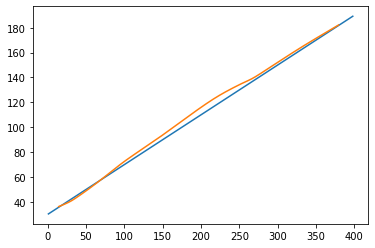

In [212]:
plt.plot(testx.reshape(398,2)[:,0:1], testx.reshape(398,2)[:,1:2])
plt.plot(predict[:,0:1], predict[:,1:2])

## Teaching NN sine or cosine wave

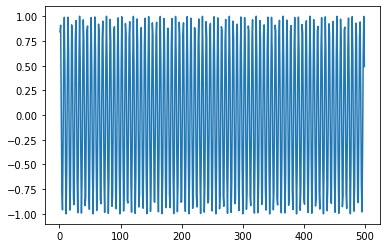

In [213]:
x = numpy.arange (1,500,1)
y = numpy.sin(x)
plt.plot(x,y)

In [214]:
trainx, testx = x[0:int(0.8*(len(x)))], x[int(0.8*(len(x))):]
trainy, testy = y[0:int(0.8*(len(y)))], y[int(0.8*(len(y))):]
train = numpy.array(list(zip(trainx,trainy)))
test = numpy.array(list(zip(trainx,trainy)))

In [215]:
look_back = 1
trainx,trainy = create_dataset(train, look_back)
testx,testy = create_dataset(test, look_back)
trainx = numpy.reshape(trainx, (trainx.shape[0], 1, 2))
testx = numpy.reshape(testx, (testx.shape[0], 1, 2))

In [216]:
model = Sequential()
model.add(LSTM(512, return_sequences = True, input_shape = (trainx.shape[1],
2)))
model.add(LSTM(256,input_shape = (trainx.shape[1], 2)))
model.add(Dense(2))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainx, trainy, epochs = 2000, batch_size = 10, verbose = 2, shuffle
= False)
model.save_weights('LSTMBasic2.h5')
model.load_weights('LSTMBasic2.h5')
predict = model.predict(testx)

Epoch 1/2000
40/40 - 4s - loss: 23373.2988
Epoch 2/2000
40/40 - 1s - loss: 21666.8867
Epoch 3/2000
40/40 - 1s - loss: 20479.6406
Epoch 4/2000
40/40 - 1s - loss: 19393.5195
Epoch 5/2000
40/40 - 1s - loss: 18380.0449
Epoch 6/2000
40/40 - 1s - loss: 17429.3750
Epoch 7/2000
40/40 - 1s - loss: 16539.5000
Epoch 8/2000
40/40 - 1s - loss: 15703.0146
Epoch 9/2000
40/40 - 1s - loss: 14914.2139
Epoch 10/2000
40/40 - 1s - loss: 14169.4424
Epoch 11/2000
40/40 - 1s - loss: 13463.8408
Epoch 12/2000
40/40 - 1s - loss: 12830.4658
Epoch 13/2000
40/40 - 1s - loss: 12217.6758
Epoch 14/2000
40/40 - 1s - loss: 11605.4072
Epoch 15/2000
40/40 - 1s - loss: 11043.0479
Epoch 16/2000
40/40 - 1s - loss: 10496.2451
Epoch 17/2000
40/40 - 1s - loss: 10039.9619
Epoch 18/2000
40/40 - 1s - loss: 9606.2285
Epoch 19/2000
40/40 - 1s - loss: 9168.6807
Epoch 20/2000
40/40 - 1s - loss: 8680.3799
Epoch 21/2000
40/40 - 1s - loss: 8298.2158
Epoch 22/2000
40/40 - 1s - loss: 7924.9229
Epoch 23/2000
40/40 - 1s - loss: 7554.5156
Epo

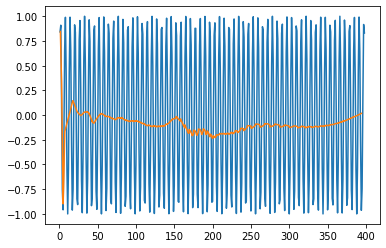

In [217]:
plt.plot(trainx.reshape(398,2)[:,0:1], trainx.reshape(398,2)[:,1:2])
plt.plot(predict[:,0:1], predict[:,1:2])

# Training Parabola

## Training random graph

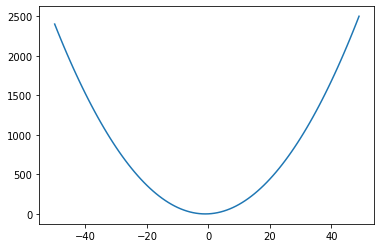

In [225]:
x = numpy.arange(-50, 50, 1)
y = x**2 + 2*x +2
plt.plot(x,y)

In [226]:
trainx, testx = x[0:int(.8*(len(x)))], x[int(.8*(len(x))):]
trainy, testy = y[0:int(.8*(len(y)))], y[int(.8*(len(y))):]
train = numpy.array(list(zip(trainx,trainy)))
test = numpy.array(list(zip(trainx,trainy)))

In [227]:
look_back = 1
trainx, trainy = create_dataset(train, look_back)
testx, testy = create_dataset(test, look_back)

trainx = numpy.reshape(trainx, (trainx.shape[0], 1, 2))
testx = numpy.reshape(testx, (testx.shape[0], 1, 2))

In [229]:
model = Sequential()
model.add(LSTM(512, return_sequences = True, input_shape = (trainx.shape[1],2)))
model.add(LSTM(256, input_shape = (trainx.shape[1], 2)))
model.add(Dense(2))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainx, trainy, epochs = 2000, batch_size = 10, verbose = 2, shuffle= False)
model.save_weights('LSTMBasic1.h5')
model.load_weights('LSTMBasic1.h5')
predict = model.predict(testx)

Epoch 1/2000
8/8 - 6s - loss: 373258.0938
Epoch 2/2000
8/8 - 0s - loss: 370989.0000
Epoch 3/2000
8/8 - 0s - loss: 368333.0312
Epoch 4/2000
8/8 - 0s - loss: 365676.4688
Epoch 5/2000
8/8 - 0s - loss: 363291.8438
Epoch 6/2000
8/8 - 0s - loss: 361865.8438
Epoch 7/2000
8/8 - 0s - loss: 360893.0000
Epoch 8/2000
8/8 - 0s - loss: 360063.3438
Epoch 9/2000
8/8 - 0s - loss: 359275.8750
Epoch 10/2000
8/8 - 0s - loss: 358513.2188
Epoch 11/2000
8/8 - 0s - loss: 357769.7188
Epoch 12/2000
8/8 - 0s - loss: 357042.0312
Epoch 13/2000
8/8 - 0s - loss: 356327.3750
Epoch 14/2000
8/8 - 0s - loss: 355623.7188
Epoch 15/2000
8/8 - 0s - loss: 354929.6562
Epoch 16/2000
8/8 - 0s - loss: 354244.2812
Epoch 17/2000
8/8 - 0s - loss: 353566.4375
Epoch 18/2000
8/8 - 0s - loss: 352895.0938
Epoch 19/2000
8/8 - 0s - loss: 352229.6562
Epoch 20/2000
8/8 - 0s - loss: 351569.6875
Epoch 21/2000
8/8 - 0s - loss: 350914.5938
Epoch 22/2000
8/8 - 0s - loss: 350264.1250
Epoch 23/2000
8/8 - 0s - loss: 349617.8438
Epoch 24/2000
8/8 - 

In [230]:
plt.plot(trainx.reshape(398,2)[:,0:1], trainx.reshape(398,2)[:,1:2])
plt.plot(predict[:,0:1], predict[:,1:2])

ValueError: cannot reshape array of size 158 into shape (398,2)